# Blockchain based ROSCA - version 2
---

* [System Requirements (Part 1)](#System-Requirements)
  * [Model Introduction](#Model-Introduction)
  * [Requirements Analysis](#Requirements-Analysis)
  * [Differential Game](#Differential-Game)
* [System Design (Part 2)](#System-Design)
  * [Differential Specification](#Differential-Specification)
    0. [Dependencies](#0.-Dependencies)
    1. [State Variables](#1.-State-Variables)
    2. [Reward + Cost](#2.-Reward-+-Cost)
    3. [Agent Strategies Definition](#2.-Agent-Strategies-Definition)
    4. [Agent Behaviours Definition](#2.-Agent-Behaviours-Definition)
    5. [Policy Functions](#3.-Policy-Functions)
    6. [State Update Functions](#4.-State-Update-Functions)
    7. [Partial State Update Blocks](#5.-Partial-State-Update-Blocks)
    8. [Configuration](#6.-Configuration)
    9. [Execution](#7.-Execution)
    10. [Simulation Output Preparation](#8.-Simulation-Output-Preparation)
    11. [Simulation Analysis](#9.-Simulation-Analysis)  
* [System Validation (Part 3)](#System-Validation)
    * [Model Limitations](#Model-Limitations)
    * [Model Improvements](#Model-Improvements)
---

# System Requirements

<center><img src="images/step1.png" alt="Engineering Design Process, phase 1 - System requirements" width="60%"/>
    
## Model Introduction
In this notebook we improve on our first ROSCA model, a blockchain based simulation environment for informal savings and credit institutions. 

Previously, we layed out the basic dynamics of a blockchain based rosca and implemented the core mechanisms: the ability to contribute and recieve money from the rosca circle. We also identified our initial models limitations: namely, the lack of dimension to the agents and incentives to influence decisions. 

Since we are modelling a social and economic system, we are constantly asking what our agents will do. Answering this is a second step towards an abstracted (but realistic) simulation environment, where we essentially outline the economic incentives associated with the choices the agents can make. More specifically, what economics incentives are associated with the choice to behave honestly, or dishonetly. 

In the worse case senario, multiple agents from the same circle behave dishonestly, resulting in the rest of the agents not recieving their full amount they contributed (as seen in version 1) or disincentiving them to continue contributing. How can we create policies that are robust to network uncertainty and strategic interactions?

We will develop these questions throughout, getting insight from our models and simulations.

## Requirements Analysis

For this version, we extend our ROSCA model to focus on two things: 
1. Producing rich agent-based models 
2. Programming incentives and seeing how agent behaviours map to these the incentives (rewards, penalties, general outcomes). 


## Differential Game

> Game theory is the study of the ways in which interacting choices of economic agents produce outcomes with respect to the preferences (or utilities) of those agents

> In game theory, differential games are a group of problems related to the modeling and analysis of conflict in the context of a dynamical system

### Agents' Dilemma

In this simulation the agents are faced with two choices: 
1. To cheat and steal the pot - an agent is faced with this choice once for the entire duration 
2. To contribute money - an agent is faced with this choice every timestep (month)

We explore these choices using a differential game. Assuming the choice to steal the pot is expensive (incurs a heavy cost) and agents do not undertake this task unless their is an expected ROI is greater that penalties incurred or the incentives associated good behaviour such as: a higher credit-score. 

![Feedback](./images/feedback.png)

At each point in time both Contributer's and Cheaters must make a decision about how to act. 
Cheaters and Contributers beliefs about the expected returns on their actions as estimated by their observations of the other's actions over time.
For an example: if an agent sees others either aren't contributing or have stolen the pool, this will heavily influence their decision on wether to continue behaving honestly.

![Flow](./images/flow_v2.png)

---

# System Design

<center><img src="images/step2.png" alt="Engineering Design Process, phase 2 - System requirements" width="60%"/>

## Differential Specification

![Differential Specification](./images/diff.png)

In this notebook, we explore the "Non-Equibrium Dynamics" that arise from introducing ROI estimation as feedback to the 'Player decision' policy of users. 

## 0. Dependencies

In [27]:
# Standard libraries: https://docs.python.org/3/library/
import math
import secrets
import random
from datetime import timedelta

# Logic
from circle import initialise_circle_state
from chain import create_block
from agents import (AgentData, update_contribution_amount, verify_allocated_amount, get_monthly_default_count, calculate_agent_amount)

# Analysis and plotting modules
import pandas as pd
import numpy as np

In [28]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# 1. Agent Strategies Definition
> Here we define our behavioral models in which agents interact according to their own heuristic strategies

#### Three types of contributers:

In [29]:
def honest_contributer(reward, cost):
    if(cost > reward): # contributes just as long as cost isn't greater than reward 
       return False
    else :
        return True    


def influenced_contributer(reward, cost):
    if((0.25 * cost) > reward): # gets discouraged from contributing if cost > 25% of reward
       return False
    else :
        return True 

def broke_contributer(reward, cost):       
    if(random.random() < 0.05): # 5% chance this contributer doesn't have enough money to contribute
       return False
    else :
        return True 

#### Two types of 'cheaters' (those who are allocated the pot once each timestep):

In [30]:
def honest_allocator(reward, cost):   
    if(cost > reward): # doesn't steal pot as long as cost isnt greater than reward 
       return False
    else:
        return True    

def greedy_allocator(reward, cost):   
    risk = random.random()
    if((reward > cost) or (risk < 0.5 and reward != 0)): # if reward is greater than cost or agent accepts risk of not being caught
        return True
    else:
        return False  

# 2. State Variables

### Assign strategies to individual agents

In [31]:
def assign_contributing_strategy(i):
    """ ASSIGN CONTRIBUTING STRATEGY """
    contributer_strategies = [honest_contributer, influenced_contributer, broke_contributer]
    tmp = random.choice(contributer_strategies)
    print("agent: " + str(i) + ". contrib: " + str(tmp))
    return tmp

def assign_allocating_strategy(i):
    """ ASSIGN ALLOCATING POOL STRATEGY """
    strategies = [honest_allocator, greedy_allocator]
    tmp = random.choice(strategies)
    print("agent: " + str(i) + ". alloc: " + str(tmp) + "\n")
    return tmp

### Genesis state

In [32]:
#used with stochastic processes to make experiments repeatable
seed = {}

# define agents each agreeing to contribute 300£ a month
def get_initial_deposits(n):
    agent = [AgentData(secrets.token_bytes(48), 300, i, 0, False, 0, False, 0, assign_contributing_strategy(i), assign_allocating_strategy(i))
             for i in range(n)]       
    return agent

agent_genesis = get_initial_deposits(10)

agent: 0. contrib: <function broke_contributer at 0x12366db80>
agent: 0. alloc: <function honest_allocator at 0x123416550>

agent: 1. contrib: <function influenced_contributer at 0x12366d9d0>
agent: 1. alloc: <function greedy_allocator at 0x12366d790>

agent: 2. contrib: <function honest_contributer at 0x1224fc670>
agent: 2. alloc: <function honest_allocator at 0x123416550>

agent: 3. contrib: <function honest_contributer at 0x1224fc670>
agent: 3. alloc: <function honest_allocator at 0x123416550>

agent: 4. contrib: <function influenced_contributer at 0x12366d9d0>
agent: 4. alloc: <function greedy_allocator at 0x12366d790>

agent: 5. contrib: <function broke_contributer at 0x12366db80>
agent: 5. alloc: <function honest_allocator at 0x123416550>

agent: 6. contrib: <function honest_contributer at 0x1224fc670>
agent: 6. alloc: <function honest_allocator at 0x123416550>

agent: 7. contrib: <function influenced_contributer at 0x12366d9d0>
agent: 7. alloc: <function greedy_allocator at 0x12

In [33]:
# Initial Conditions
genesis_state = {
    'Contributers_On': True, # contributers are active
    'Cheaters_On': False, # cheaters are inactive
    'Total_Volume': 0, # total volume of pool activity (GBP)
    'Honest_Volume': 0, # volume of honest (contributed) activity (GBP)
    'Dishonest_Volume': 0, # volume of dishonest (non-contributed) activity (GBP)
    'Cheats_Volume': 0, # volume of cheater activity (GBP)
    'Contributers_Rating': 0, # ratings of contributing agent
    'Contributers_Cost': 0, # cost incurred by contributers
    'Contributers_Reward': 0, # rewards collected by contributers
    'Cheaters_Cost': 0, # costs incurred by cheaters
    'Cheater_Reward': 0, # rewards (profit) achieved by cheating 
    'timestep': 0,
    'agent_data': agent_genesis,
    'Duration': 10
}

In [ ]:
initial_conditions = {
    'pool_state': genesis_state
}

# 3. Reward + Cost

> Here we outline our State Dependant Reward and Cost Functions which characterise the players utilities 

In [34]:
# contributers's reward per round contributed => amount agreed
def contributers_reward(data, s):
    return calculate_agent_amount(data, s['timestep'], s['Duration'])

# Contributer's cost per round cheater acts => amount defaulted if at all
def contributer_cost(s):
    share = 0.1
    return (share * s['Cheats_Volume'])

# Cheater's reward per cheat
def cheater_reward(s, allocation_amt):
    print("check allocation_amt: " + str(allocation_amt) + " contributed: " + str(s.contributed_amt))
    if(s.contributed_amt >= allocation_amt):
        return 0.0
    else :    
        return allocation_amt - s.contributed_amt # Pot amount - Contributed amount

# Cheater's cost per cheat caught
delta = 0.05
def cheater_cost(s, allocation_amt):
    return (delta * allocation_amt) + allocation_amt - s.contributed_amt

# 4. Agent Behaviours Definition
> We can now define our two types of agents

#### 1. A contributer 
Contributer motivated to contribute their share if reward is greater than the cost of other agents stealing 

In [35]:
def p_contributer(state, agent):
    act = False
    cost = contributer_cost(state)
    reward = contributers_reward(agent, state)
    agent_strategy = agent.contribute_strategy
    
    if(agent.defaulted):
        return act

    print("Shall I contribute? reward: " + str(reward) + " cost: " + str(0.25 * cost) + " strategy: " + str(agent_strategy))
    if (agent_strategy(reward, cost)):
        act = True
        agent.rating += 0.2 # increase rating 
        state['Contributers_Rating'] += 0.2
        agent.contributed_amt += agent.amount # update agent contributed amount

    return act

#### 2. A cheater
Cheater motivated to steal the pot if reward is greater than their amount contributed so far + can take the risk of being caught

In [36]:
def p_cheater(state, agent, allocation_amt):
    act = False
    reward = cheater_reward(agent, allocation_amt)
    cost = cheater_cost(agent, allocation_amt)
    agent_strategy = agent.allocate_strategy
    
    if(reward == 0): return act
    
    print("Shall I steal? reward: " + str(reward) + " cost: " + str(cost) + " strategy: " + str(agent_strategy))

    if(agent_strategy(reward, cost)):
        print("YESSSS - YOLO")
        act = True
        state['Cheats_Volume'] += reward 
        state['Cheater_Reward'] = reward
        state['Cheaters_Cost'] = cost
    else :
        state['Contributers_Reward'] = reward    

    return act

# 5. Policy Functions

> In this section Policies are defined for our cheaters and contributers choices.

### In our differential specification, we focus on two policies:  

#### 1. A system decision - Monthly collection policy which leads to -> A players decision - the decision to contribute the amount set out or not

We can now define these policies:

In [37]:
def p_intitiate_monthly_deposits(params, substep, state_history, previous_state):
    month_sum = 0.0
    expected_month_sum = 0.0
    agent_data = previous_state['agent_data']
    month = previous_state['timestep']

    print("\n" + "STARTING ROSCA MONTH " + str(month))
    
    # for each agent add their monthly contribution to the collected pool
    for x in range(0, len(agent_data)):
        agent_contribution = agent_data[x].amount
        expected_month_sum += agent_contribution

        # player decision - initiate contributers behaviour
        if(p_contributer(previous_state, agent_data[x]) == True):
            month_sum += agent_contribution # c - from differential eq
        else :
            print("Contributer default: GBP" + str(agent_contribution))
       
    previous_state['Total_Volume'] = expected_month_sum
    previous_state['Honest_Volume'] = month_sum
    previous_state['Dishonest_Volume'] = expected_month_sum - month_sum

    print("Total deposited amount: GBP" + str(previous_state['Honest_Volume']) + " - Defaulted amount: " + str(previous_state['Dishonest_Volume']))

    return {'collected_amount': month_sum}



#### 2. A system decision - Monthly allocation policy which leads to -> A players decision - the decision to steal the pool allocated to you or not

In [38]:
def p_allocate_pool(params, substep, state_history, previous_state):
    block_agent_data = previous_state['agent_data']
    pool_amount = previous_state['Honest_Volume']
    timestep = previous_state['timestep']

    for x in range(0, len(block_agent_data)):
        if(block_agent_data[x].standing == timestep and block_agent_data[x].taken == False):
            allocation_amt = calculate_agent_amount(block_agent_data[x], timestep+1, previous_state['Duration']) # a - from differential eq

            print("verify: allocation_amt: " + str(allocation_amt) + ", pool_amount" + str(pool_amount))
            if(verify_allocated_amount(block_agent_data[x], allocation_amt, pool_amount) == True):    
                block_agent_data[x].taken = True
                pool_amount -= allocation_amt

                print("Allocating agent: " + str(block_agent_data[x].pubkey) + ", standing: " + str(block_agent_data[x].standing) + ", amount: GBP" + str(allocation_amt))
                
            else :
                print("Not enough money in pool to allocate agent full amount of: " + str(allocation_amt) + "\n")    
                allocation_amt = pool_amount
                block_agent_data[x].taken = False
                pool_amount = 0.0

            # reset variables
            previous_state['Cheaters_Cost'] = 0
            previous_state['Cheats_Volume'] = 0  
            previous_state['Cheater_Reward'] = 0
            
            # player decision - initiate cheater behaviour
            if(p_cheater(previous_state, block_agent_data[x], allocation_amt) == True):
                previous_state['Contributers_Cost'] += contributer_cost(previous_state)
                previous_state['Cheaters_On'] = True
                print("Allocator default: GBP" + str(previous_state['Cheater_Reward']))
                block_agent_data[x].defaulted = True

            block_agent_data[x].balance += allocation_amt
#         previous_state['Honest_Volume'] -= pool_amount
    return {'pool_amount' : pool_amount}

# 6. State Update Functions

So far we have described the system of rewards and the simple strategies being evaluated, but in order to implement a differential game one must also explicit encode the mechanisms. Mechanisms are the functions that map decisions to changes in the system state.

In [39]:
def s_updatepool(params, substep, state_history, previous_state, policy_input):
    """
    Update the pool state according to the differential equation (1):
    current_pool_state + collected_amount - allocation_amount
    """
    
    p_collected_amt = policy_input['collected_amount']
    p_pool_amt = policy_input['pool_amount']
    
    return 'pool_state', genesis_state

# 7. Partial State Update Blocks

In [40]:
partial_state_update_blocks = [
    {
        'policies': {
            'collected_amount': p_intitiate_monthly_deposits,
            'pool_amount': p_allocate_pool
        }, 
        # State variables
        'variables': {
            'pool_state': s_updatepool            
        }
    }
]

# 8. Configuration

In [41]:
# system_params = {
#     'duration': [10], # duration of rosca circle
# }
# system_params

sim_config = config_sim({
    "N": 1,
    "T": range(10),
#     "M": system_params
})

In [42]:
from cadCAD import configs
del configs[:] # Clear any prior configs

In [43]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_conditions,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)
configs[-1].__dict__

{'sim_config': {'N': 1,
  'T': range(0, 10),
  'M': [{}],
  'subset_id': 0,
  'subset_window': deque([0, None]),
  'simulation_id': 0,
  'run_id': 0},
 'initial_state': {'Contributers_On': True,
  'Cheaters_On': False,
  'Total_Volume': 0,
  'Honest_Volume': 0,
  'Dishonest_Volume': 0,
  'Cheats_Volume': 0,
  'Contributers_Rating': 0,
  'Contributers_Cost': 0,
  'Contributers_Reward': 0,
  'Cheaters_Cost': 0,
  'Cheater_Reward': 0,
  'timestep': 0,
  'agent_data': [<agents.AgentData at 0x111eb8100>,
  'Duration': 10},
 'seeds': {},
 'env_processes': {},
 'exogenous_states': {},
 'partial_state_updates': [{'policies': {'collected_amount': <function __main__.p_intitiate_monthly_deposits(params, substep, state_history, previous_state)>,
    'pool_amount': <function __main__.p_allocate_pool(params, substep, state_history, previous_state)>},
   'variables': {'pool_state': <function __main__.s_updatepool(params, substep, state_history, previous_state, policy_input)>}}],
 'policy_ops': [<func

{'sim_config': {'N': 1,
  'T': range(0, 10),
  'M': [{}],
  'subset_id': 0,
  'subset_window': deque([0, None]),
  'simulation_id': 0,
  'run_id': 0},
 'initial_state': {'Contributers_On': True,
  'Cheaters_On': False,
  'Total_Volume': 0,
  'Honest_Volume': 0,
  'Dishonest_Volume': 0,
  'Cheats_Volume': 0,
  'Contributers_Rating': 0,
  'Contributers_Cost': 0,
  'Contributers_Reward': 0,
  'Cheaters_Cost': 0,
  'Cheater_Reward': 0,
  'timestep': 0,
  'agent_data': [<agents.AgentData at 0x111eb8100>,
  'Duration': 10},
 'seeds': {},
 'env_processes': {},
 'exogenous_states': {},
 'partial_state_updates': [{'policies': {'collected_amount': <function __main__.p_intitiate_monthly_deposits(params, substep, state_history, previous_state)>,
    'pool_amount': <function __main__.p_allocate_pool(params, substep, state_history, previous_state)>},
   'variables': {'pool_state': <function __main__.s_updatepool(params, substep, state_history, previous_state, policy_input)>}}],
 'policy_ops': [<func

# 7. Execution

In [44]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)

In [45]:
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 14)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded

STARTING ROSCA MONTH 0
calculate_agent_amount: 0 0 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function broke_contributer at 0x12366db80>
calculate_agent_amount: 0 0 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function influenced_contributer at 0x12366d9d0>
calculate_agent_amount: 0 0 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function honest_contributer at 0x1224fc670>
calculate_agent_amount: 0 0 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <fun

STARTING ROSCA MONTH 2
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function broke_contributer at 0x12366db80>
Contributer default: GBP300
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function influenced_contributer at 0x12366d9d0>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function honest_contributer at 0x1224fc670>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function honest_contributer at 0x1224fc670>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function influenced_contributer at 0x12366d9d0>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function broke_contributer at 0x12366db80>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <


calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function broke_contributer at 0x12366db80>
Contributer default: GBP300
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function influenced_contributer at 0x12366d9d0>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function honest_contributer at 0x1224fc670>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function honest_contributer at 0x1224fc670>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function influenced_contributer at 0x12366d9d0>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function broke_contributer at 0x12366db80>
calculate_agent_amount: 600 600 missing: 0
Shall I contribute? reward: 3000 cost: 0.0 strategy: <function honest_contri

# 8. Simulation Output Preparation
> The simulation results are returned as a list of Python dictionaries, which we then convert to a Pandas dataframe. At this stage of the process we'll manipulate and analyze our results to answer questions about our model.

In [55]:
simulation_result = pd.DataFrame(raw_result)
df = simulation_result.copy()

df.iloc[:,0:12]

,Contributers_On,Cheaters_On,Total_Volume,Honest_Volume,Dishonest_Volume,Cheats_Volume,Contributers_Rating,Contributers_Cost,Contributers_Reward,Cheaters_Cost,Cheater_Reward,timestep
0,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,True,False,3000.0,3000.0,0.0,0.0,2.0,0.0,2700.0,0.0,0.0,1
2,True,False,3000.0,3000.0,0.0,0.0,4.0,0.0,2400.0,0.0,0.0,2
3,True,False,3000.0,2700.0,300.0,0.0,5.8,0.0,1800.0,0.0,0.0,3
4,True,False,3000.0,3000.0,0.0,0.0,7.8,0.0,1800.0,0.0,0.0,4
5,True,True,3000.0,3000.0,0.0,1500.0,9.8,150.0,1800.0,1650.0,1500.0,5
6,True,True,3000.0,2400.0,600.0,0.0,11.4,150.0,600.0,0.0,0.0,6
7,True,True,3000.0,2700.0,300.0,0.0,13.2,150.0,600.0,0.0,0.0,7
8,True,True,3000.0,2700.0,300.0,300.0,15.0,180.0,600.0,435.0,300.0,8
9,True,True,3000.0,2400.0,600.0,0.0,16.6,180.0,600.0,0.0,0.0,9


,Contributers_On,Cheaters_On,Total_Volume,Honest_Volume,Dishonest_Volume,Cheats_Volume,Contributers_Rating,Contributers_Cost,Contributers_Reward,Cheaters_Cost,Cheater_Reward,timestep
0,True,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,True,False,3000.0,3000.0,0.0,0.0,2.0,0.0,2700.0,0.0,0.0,1
2,True,False,3000.0,3000.0,0.0,0.0,4.0,0.0,2400.0,0.0,0.0,2
3,True,False,3000.0,2700.0,300.0,0.0,5.8,0.0,1800.0,0.0,0.0,3
4,True,False,3000.0,3000.0,0.0,0.0,7.8,0.0,1800.0,0.0,0.0,4
5,True,True,3000.0,3000.0,0.0,1500.0,9.8,150.0,1800.0,1650.0,1500.0,5
6,True,True,3000.0,2400.0,600.0,0.0,11.4,150.0,600.0,0.0,0.0,6
7,True,True,3000.0,2700.0,300.0,0.0,13.2,150.0,600.0,0.0,0.0,7
8,True,True,3000.0,2700.0,300.0,300.0,15.0,180.0,600.0,435.0,300.0,8
9,True,True,3000.0,2400.0,600.0,0.0,16.6,180.0,600.0,0.0,0.0,9


<AxesSubplot:xlabel='timestep'>

<AxesSubplot:xlabel='timestep'>

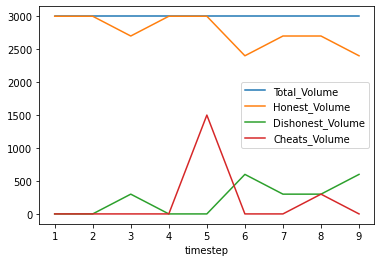

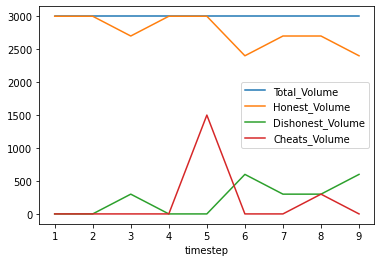

In [56]:
df.iloc[1:10].plot('timestep', 
            ['Total_Volume',
             'Honest_Volume',
             'Dishonest_Volume',
             'Cheats_Volume',])

#### Here we observe the evolution of the three different types of volumes over the time period. We see two dinstinct things:
1. The agents are overall inclinated towards behaving honestly - with the honest volume somewhat stable
2. Following an act of a single agent cheating and stealing the pot (without contributing further) decintivises the other agents, and results in the following months to have an increase in Dishonest behaviour (agent not contributing)

-----

<AxesSubplot:xlabel='timestep'>

<AxesSubplot:xlabel='timestep'>

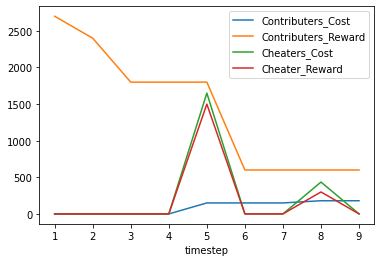

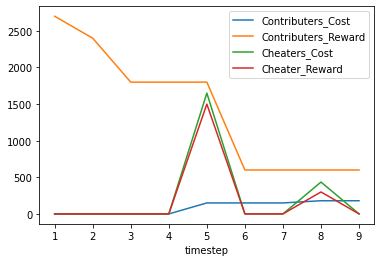

In [47]:
df.iloc[1:10].plot('timestep', ['Contributers_Cost',
             'Contributers_Reward',
             'Cheaters_Cost',
             'Cheater_Reward'])

#### Here we map out our contributers and cheaters costs vs rewards. We see:
1. The contributers that benefit from this scheme the most are those that recieve the pot at the beginning of the rosca circle, towards the end an agent would've contributed almost all/all the money they put in. 
2. Similary a cheater benefits if they deciede to steal at the begginning of the circle, however this is negligible as the cost of getting caught is always higher.
3. Cheating negitvley impacts the entire circle as they all share the cost of the amount that was stolen, however this is almost always negligible also, as cheaters face a penality when caught

---


#### We set it up so that the rewards net out on average, funneling the cheater penalties to contributers. In the section below, we use the pandas builtins to compute some extra fields to explore the financial flows

In [49]:
df["Cumulative_Cheating_Volume"]= df['Cheats_Volume'].cumsum()
df["Cumulative_Cheating_Rewards"]= df['Cheater_Reward'].cumsum()

df["Cumulative_Contributers_Cost"]= df['Contributers_Cost'].cumsum()
df["Cumulative_Contributer_Rewards"]= df['Contributers_Reward'].cumsum()

df["Cumulative_Cheating_Penalties"]= df['Cheaters_Cost'].cumsum()
df["Cumulative_Cheating_Profit"] = df["Cumulative_Cheating_Rewards"]-df["Cumulative_Cheating_Penalties"]

df["Cumulative_Contributer_Profit"] = df["Cumulative_Contributer_Rewards"]-df["Cumulative_Contributers_Cost"]
df["Cumulative_Contributer_ROI"] = df["Cumulative_Contributer_Profit"]/df["Cumulative_Contributers_Cost"]

df["Running_Cheating_Volume_Fraction"]=df["Cumulative_Cheating_Volume"]/df["Total_Volume"].cumsum()

df["Cumulative_Net_Profit"] = df["Cumulative_Contributer_Profit"] + df["Cumulative_Cheating_Profit"]

<AxesSubplot:>

<AxesSubplot:>

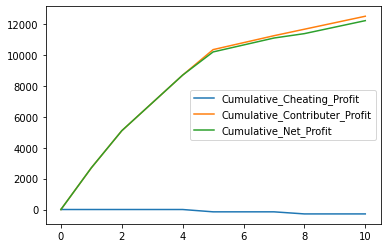

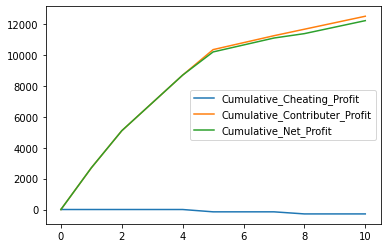

In [50]:
df[['Cumulative_Cheating_Profit', "Cumulative_Contributer_Profit", "Cumulative_Net_Profit"]].plot()

0.06333333333333332
0.06333333333333332


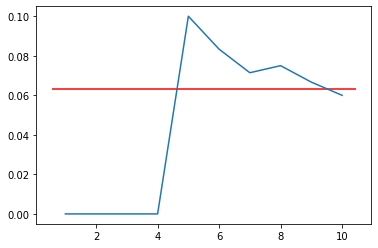

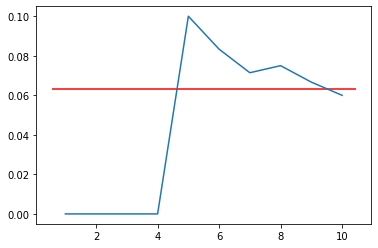

In [51]:
import matplotlib.pyplot as plt

df["Running_Cheating_Volume_Fraction"].plot()
h = df["Running_Cheating_Volume_Fraction"].median()
ax = plt.axis()
plt.hlines(h, ax[0], ax[1], 'r')
print(h)

52.5
52.5


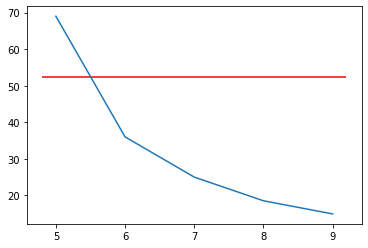

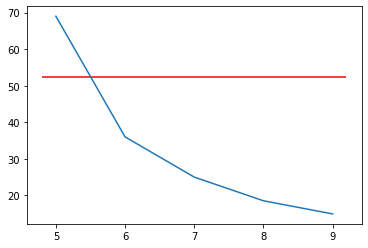

In [52]:
df["Cumulative_Contributer_ROI"].iloc[1:10].plot()
h = df["Cumulative_Contributer_ROI"].median()
ax = plt.axis()
plt.hlines(h, ax[0], ax[1], 'r')
print(h)

# System Validation

<center><img src="images/step3.png" alt="Engineering Design Process, phase 1 - System requirements" width="60%"/>

By understanding the temporal dynamics of a game it is possible to get a much clearer understanding of what is going on and to make decisions about trade-offs. In this case, we can monitor and manage cheating rates through ensuring contributers aren't affected by cheaters' decisions by making sure they are caught and penalties are imposed.
This serves to ensure cheating remains bounded and the system stays self-sustaining.

## What did we achieve in this notebook?
[Requirements Analysis](#Requirements-Analysis)

This notebook introduced a key element of distributed systems: the addition of a rich agent based model. We programmed a range of different types of agents in different senarios: honest contributer, influenced contributer, greedy allocator etc, and  economic incentives associated with the choices.

All agents on the network act in a way to maximise their reward and minimise their cost. In this simulation we observed different types of agents interact with each other, eg - if one agent steals the pot how does this influence the actions of others in the circle. 
    
We introduced incentives and rules which serves to influence decision making in the protocol, eg - an agents decision not to contribute only affects their ROI and rating, therefore in the interest of maximising your pot it is better to contribute.    

---

## Model Limitations
While we have so far built a transparent, decentalised peer-to-peer ROSCA model, we haven't met our goal of our system being democratic. While agents are free to make their own decisions, there is no system for governance. 

---

## Model Improvements
To further fit real world applications we could:
1. Set different contribution amounts for different agents
2. Order standing of agents according to their 'trust-rating'

Finally, to be able to evaluate or goal of 'a fair, democratic, decentralised model solution of ROSCA', we design and implement our final mechanism - a system for governance, consistiing of:
1. A mechanism for voting eg: to change standing of an agent (turn in which they recieve the pot)
2. A mechanism for borrowing from the pot